In [2]:
import datetime
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, train_test_split

from xgboost import XGBRegressor, DMatrix
import xgboost

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def hist_columns(dataset, chosen_columns):
    for column in chosen_columns:
        print(column)
        train[column].hist(bins=50)
        plt.title(column)
        plt.show()

Importing data and referencing columns

In [4]:
train_columns = ['PropertyID', 'Town', 'Bedrooms', 'Bathroom', 'PropertyType', 'DistanceFromCBD', 'Landsqm', 'floorsqm', 'YearBuilt', 'Region', 'TownDensity', 'SaleDate', 'SalePrice']
test_columns = ['PropertyID', 'Town', 'Bedrooms', 'Bathroom', 'PropertyType', 'DistanceFromCBD', 'Landsqm', 'floorsqm', 'YearBuilt', 'Region', 'TownDensity', 'SaleDate']
test = pd.read_csv('test.csv', usecols=test_columns)
train =pd.read_csv('train.csv', usecols=train_columns)
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 13 columns):
PropertyID         7700 non-null int64
SaleDate           7700 non-null object
Town               7700 non-null object
Bedrooms           7700 non-null int64
Bathroom           5788 non-null float64
PropertyType       7700 non-null object
DistanceFromCBD    7700 non-null float64
Landsqm            5162 non-null float64
floorsqm           2927 non-null float64
YearBuilt          3381 non-null float64
Region             7700 non-null object
TownDensity        7700 non-null float64
SalePrice          7700 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 782.1+ KB


Data Exploration and cleaning:
we can see that 4 variables (SaleDate, Town, PropertyType, Region) are not numeric and therefore we should consider them one by one and try to extract some useful features from them

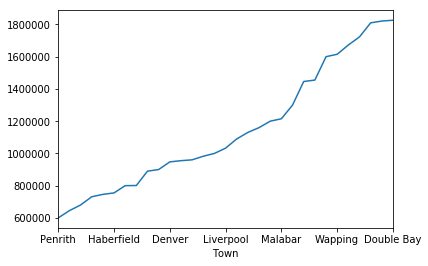

In [5]:
town_summary = train.groupby('Town').median()['SalePrice'].sort_values()
town_summary.plot()
plt.show()

Town sorted by median values over SalePrice display a reasonable linear relationship.

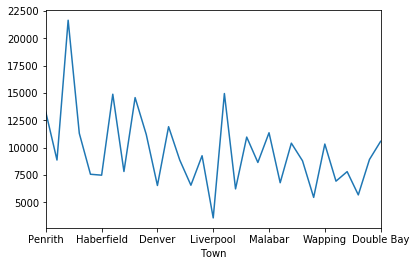

In [6]:
town_density_summary = train.groupby('Town').median()[['SalePrice', 'TownDensity']].sort_values('SalePrice')
town_density_summary['TownDensity'].plot()
plt.show()

In terms of potential information, TownDensity has the same kind of information as Town (TownDensity is the same for the same Town) but there seem to be no clear relationship between the density in itself and SalePrice.

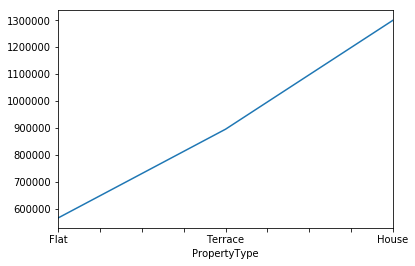

In [7]:
propertytype_summary = train.groupby('PropertyType').median()['SalePrice'].sort_values()
propertytype_summary.plot()
plt.show()

Again sorting PropertyType for SalePrice seems to be reasonably linear

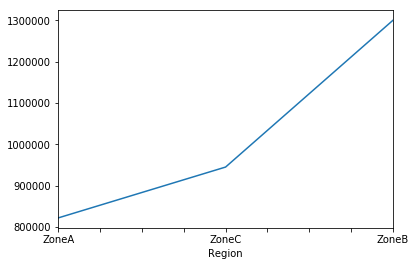

In [8]:
region_summary = train.groupby('Region').median()['SalePrice'].sort_values()
region_summary.plot()
plt.show()

Same for Region

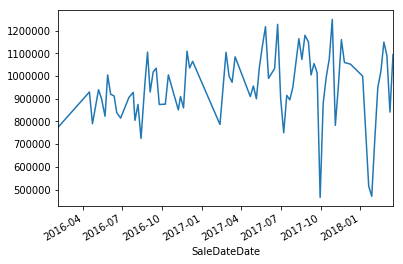

In [9]:
saledate_summary = train.groupby('SaleDate').median()['SalePrice'].sort_values()
train['SaleDateDate'] = train['SaleDate'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y'))
saledatedate_summary = train.groupby('SaleDateDate').median()['SalePrice'].sort_index()
saledatedate_summary.plot()
plt.show() 

SaleDate has intrinsic ordering in itself based on time. There seem to be no real relationship between SaleDate and SalePrice and data for SaleDate look quite noisy

In [10]:
# variable encoding
town_ref = pd.DataFrame(index=town_summary.index, columns=['Town'], data=list(range(len(town_summary)))).to_dict()
propertytype_ref = pd.DataFrame(index=propertytype_summary.index, columns=['PropertyType'], data=list(range(len(propertytype_summary)))).to_dict()
region_ref = pd.DataFrame(index=region_summary.index, columns=['Region'], data=list(range(len(region_summary)))).to_dict()
encoding = {}
encoding.update(town_ref)
encoding.update(propertytype_ref)
encoding.update(region_ref)
train.replace(encoding, inplace=True)

Based on previous observation a simple linear encoding sorted for SalePrice makes sense for Town, PropertyType and Region and now we can observe all the distributions for the features we are going to use

SalePrice


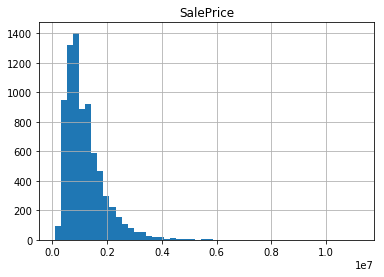

Town


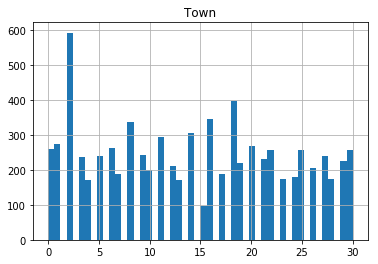

Bedrooms


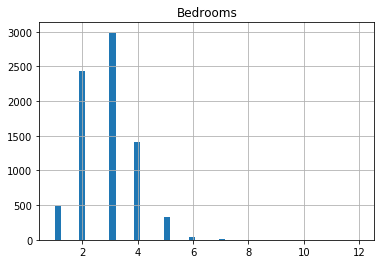

Bathroom


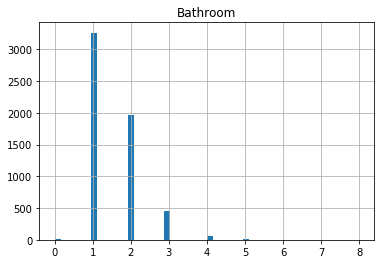

PropertyType


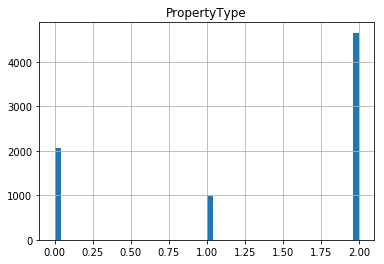

DistanceFromCBD


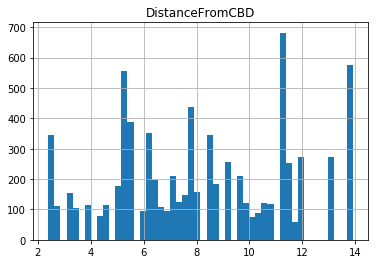

Landsqm


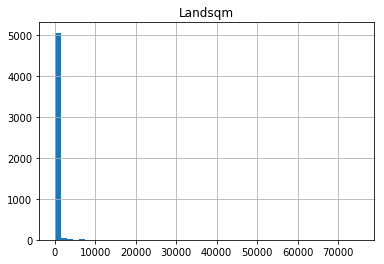

floorsqm


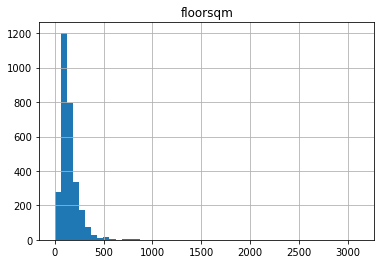

YearBuilt


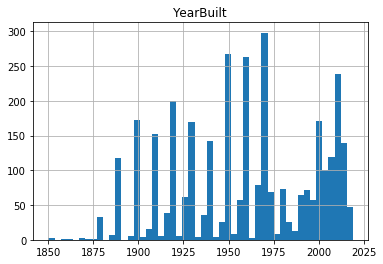

Region


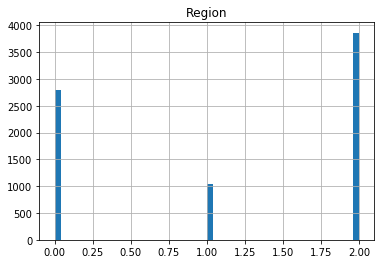

In [11]:
chosen_columns = ['SalePrice', 'Town', 'Bedrooms', 'Bathroom', 'PropertyType', 'DistanceFromCBD', 'Landsqm', 'floorsqm', 'YearBuilt', 'Region']
hist_columns(train, chosen_columns)

Floorsqm, Landsqm and SalePrice have a very obvious positive skew and they could use a transformation. Usually in these cases an obvious choice is log(x). I am going to use a log(1 + x) transformation to make it robust to values between 0 and 1 (there are a few zeros in the dataset), repeating the distribution analysis after that.

SalePrice


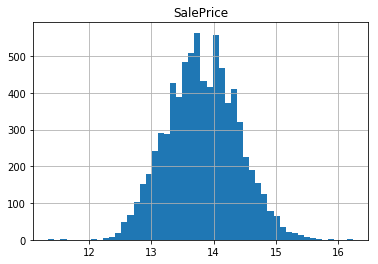

Town


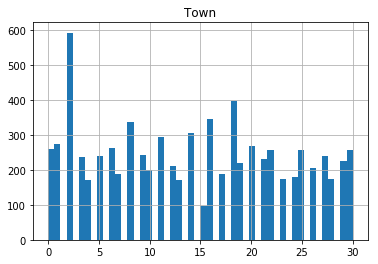

Bedrooms


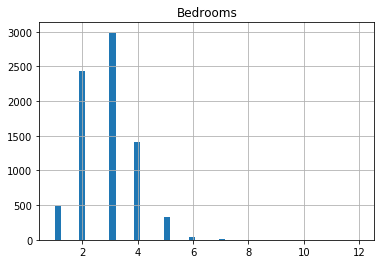

Bathroom


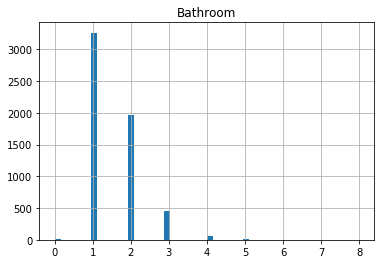

PropertyType


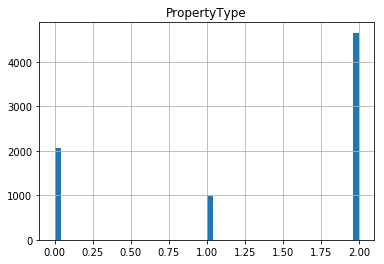

DistanceFromCBD


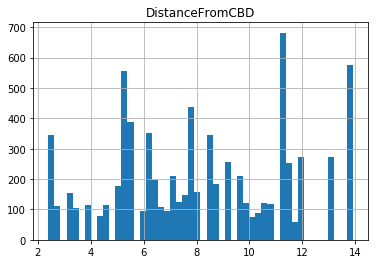

Landsqm


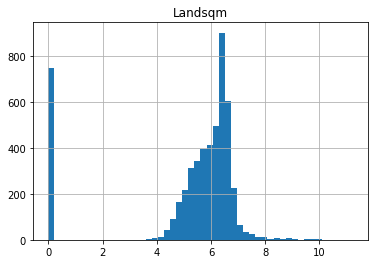

floorsqm


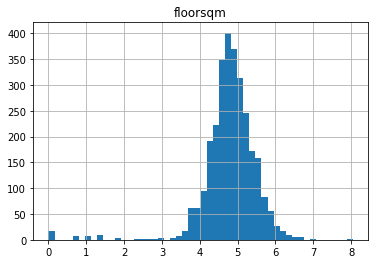

YearBuilt


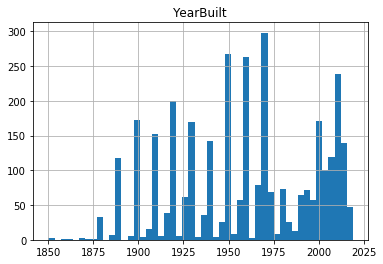

Region


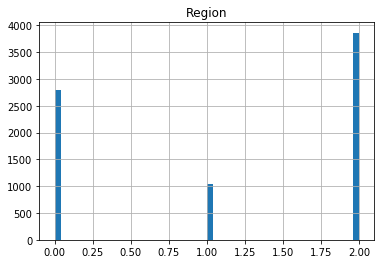

In [12]:
### reashaping features ###
skwed_features = ['Landsqm', 'floorsqm', 'SalePrice']
for feature in skwed_features:
    train[feature] = train[feature].apply(np.log1p)
hist_columns(train, chosen_columns)

All the distributions seem now ok to be fed into a Regressor.
TownDensity and SaleDate are excluded from the training. SaleDate because doesn't have a clear relationship with SalePrice, and TownDensity because the only information gain from the feature is probably already included into the new encoded variable Town.
Even including them in the model didn't really bring any improvent in the fit.

Regarding missing values, I made a few attempts imputing the values using the mean or the median for the feature
as well as just substituting all missings with zeros.
None of these solutions did better than the implicit imputation already made by xgboost that can accept a sparse matrix and handle missing values out of the box. I don't really know exactly what is the algorithm behind this but it performed better than all my attempts.

- train.fillna(0, inplace=True)
- train.fillna(train.median(), inplace=True)
- train.fillna(train.mean(), inplace=True)

In [13]:
selected_train_columns = ['Town', 'Bedrooms', 'Bathroom', 'PropertyType', 'DistanceFromCBD', 'Landsqm', 'floorsqm', 'YearBuilt', 'Region']
y = train['SalePrice'].to_numpy()
X = train[selected_train_columns].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#model
xgb = XGBRegressor()
xgb = XGBRegressor(learning_rate=0.01, n_estimators=800,
                        max_depth=10, min_child_weight=0,
                        gamma=0, subsample=0.7,
                        colsample_bytree=0.5,
                        objective='reg:linear',
                        seed=27,
                        reg_alpha=0,
                        reg_lambda=0)
xgb.fit(X_train, y_train)
#model evaluation
print('XGBoost in sample')
R2in = r2_score(y_train, xgb.predict(X_train))
msein = mean_squared_error(y_train, xgb.predict(X_train))
print('R Squared: ', str(R2in))
print('mean square error: ', str(msein))
print()
print('XGBoost out of sample')
predictions = xgb.predict(X_test)
R2out = r2_score(y_test, predictions)
mseout = mean_squared_error(y_test, predictions)   
print('R Squared: ', str(R2out))
print('mean square error: ', str(mseout))
print()

XGBoost in sample
R Squared:  0.945460829604225
mean square error:  0.017216390936701773

XGBoost out of sample
R Squared:  0.8532338862116662
mean square error:  0.04804543645193416



Based on several iterations of the model searching for different values in the parameter space done mainly manually looking at the features for possible meaningful improvements, I couldn't find any significant parameter set that would make a big difference in the results. The one above is the best I could find and only slightly better than the results achieved by using the default XGBRegressor(). It could be potentially useful to perform a grid search in the parameter space for this, there is a very handy sklearn class called GridSearchCV that can be used on xgboost models, but this is beyond the scope of this excercize.

After these considerations I prepared the data for the final predictions, predicted SalePrice on the test dataset and transformed those predictions back to the original data scale, using np.expm1.

In [14]:
###########################################
### preparing test data and predictions ###
###########################################
test.replace(encoding, inplace=True)
X_final = test[selected_train_columns].to_numpy()
final_predictions = np.floor(np.expm1(xgb.predict(X_final)))
submission = test[['PropertyID']]
submission['Predictions'] = final_predictions
submission.to_csv('submission.csv', index=False)

APPENDIX:

A small snippet of code regarding a quick attempt using Ridge and Lasso regressions using cross validation and a few different parameters.
Neither of the two could do better than xgboost regressor, apparently regularization doesn't make a big difference given the dataset and the current form of the features. Both pipelines chose the minimum available alpha essentially converging to a standard linear regression model. That is also why the two outputs are so similar.

In [15]:
# imputing values since here missing are not handled
train.fillna(train.median(), inplace=True)
X = train[selected_train_columns].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

kfolds = KFold(n_splits=10, shuffle=True, random_state=27)
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lasso = make_pipeline(StandardScaler(), LassoCV(max_iter=1e7, alphas=alphas, random_state=27, cv=kfolds))
#lasso = Lasso(0.000001)
lasso.fit(X_train, y_train)

R2_lasso = r2_score(y_test, lasso.predict(X_test))
mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
print('Lasso')
print(R2_lasso)
print(mse_lasso)
print()

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=kfolds))
#ridge = Ridge(0.000001)
ridge.fit(X_train, y_train)

R2_ridge = r2_score(y_test, ridge.predict(X_test))
mse_ridge = mean_squared_error(y_test, ridge.predict(X_test))
print('Ridge')
print(R2_ridge)
print(mse_ridge)
print()

Lasso
0.7804967785057464
0.07185669639319213

Ridge
0.7805165160986746
0.07185023508381855

